In [1]:
import seaborn as sns
sns.set()

In [2]:
from static_grader import grader

# Image Classification with TensorFlow

Image classification is a common task for deep learning and neural networks.  The raw features coming in are the pixel values.  These are simple enough to deal with, but it is difficult to connect pixel values to determining whether an image is of a cat.  Older methods used a lot of clever filters, but the current best-of-breed algorithms simply throw a lot of linear algebra at the problem.

In this miniproject, you build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%.  Each of your models will be scored by comparing its accuracy to the accuracy of a reference model that we developed.  A score of 1 indicates that your model performs as well as the reference model; not that your accuracy is 100%!

You will be given both a training set and a validation set.  Ground truth values are provided for the training set.  You should train your models on this set, and then make predictions for each of the validation images.  These predictions will be submitted to the grader.

## A note on scoring

It **is** possible to score above 1 on these questions. This indicates that you've beaten our reference model&mdash;we compare our model's score on a test set to your score on a test set. See how high you can go!

## Downloading the data

We will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [3]:
!aws s3 sync s3://dataincubator-course/cifar10/ .

download: s3://dataincubator-course/cifar10/train_labels.npy to ./train_labels.npy
download: s3://dataincubator-course/cifar10/validation_images.npy to ./validation_images.npy
download: s3://dataincubator-course/cifar10/train_images.npy to ./train_images.npy


We can load in the data like so:

In [4]:
import numpy as np

train_images = np.load(open('train_images.npy', 'rb'))
train_labels = np.load(open('train_labels.npy', 'rb'))
validation_images = np.load(open('validation_images.npy', 'rb'))

In [96]:
len(validation_images)

10000

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

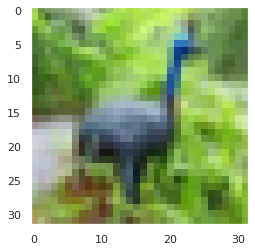

In [65]:
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
plt.imshow(train_images[6])

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [66]:
train_labels[6]

2

The human-readable names associated with this classes are

In [10]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [67]:
label_names[train_labels[6]]

'bird'

So we can see that the image above is a frog.  (Now you see it!)

# Questions

## Perceptual Delta

Since we already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, we need to develop a metric to determine the distance between two images.  We'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While we could just take RMS difference of the red, green, and blue pixels, let's be slightly more sophisticated and look at human vision for a metric.  After all, we're pretty good at image classifications, so there might be some useful optimization here.

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  We're going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

Build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that the intention here in our solution is that `images` will be a stack of images, while `base` is a single image.  Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

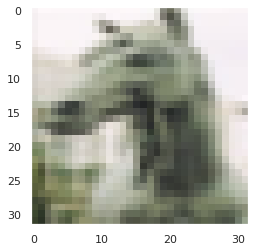

In [834]:
plt.imshow(validation_images[2714])

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
              #[0        ,1            ,2      ,3    ,4       ,5    , 6      ,7       ,8,      9]

In [59]:
#import tensorflow as tf
import numpy as np

#@tf.function
def delta_func(images, base):
    d = 0
    for i in range(32):         #32 * 32 pixels
        for j in range(32):
            x = images[i][j]   #ith-jth row col pixel of image
            y = base[i][j]  #ith-jth row col pixel of base
            delta_RGB = x - y  #del_RGB for ith jth row col [1*3]
            R = (x + y)/2    
            til_R = R[0]   #del_R for ith jth row col 
        
            del_c = (2*(delta_RGB[0] ** 2)) + (4*(delta_RGB[1] ** 2)) + (3*(delta_RGB[2] ** 2)) + til_R *(((delta_RGB[0] ** 2)-(delta_RGB[1] ** 2)))
            
            del_c = np.sqrt(del_c)                #for ith jth rol col pixel
            d += del_c
    return(d/1024)

In [62]:
deltas = []
base = validation_images[0]
distances = []
for i in range(len(train_images)):
    images = train_images[i]
    delta = delta_func(images, base)
    distances.append(delta)
distances

[0.997012272206601,
 1.0078456482263582,
 1.5193682275188336,
 0.9871081517689297,
 1.1256976354574943,
 1.2459289644105724,
 1.1562378498945198,
 0.9669830681406525,
 1.2843328300766412,
 1.3654199046849775,
 1.0052808342738309,
 1.3882527294972105,
 1.365390521064305,
 0.901567755406758,
 1.1872364502600528,
 1.1617004197326628,
 1.3892387533699413,
 0.8839785837974006,
 1.2834133251973714,
 1.096315018793959,
 1.1553607396593062,
 1.4842852013587287,
 1.0551633939856548,
 1.1305834769858525,
 1.1110656682983358,
 1.3232964181555504,
 1.3700783835915977,
 1.096224506482375,
 1.1752005993929144,
 1.7604356406769015,
 0.9930848042565833,
 1.3868778286498034,
 0.9881483435476669,
 0.8204871586401544,
 1.267374079141741,
 1.2936115644565525,
 1.1748860341813434,
 1.1257701234053519,
 1.0750131888291243,
 0.8594194924587433,
 1.2732958961328804,
 1.2588439417341848,
 1.1128457733433372,
 1.291931603100592,
 1.0501793388222491,
 1.2375519481853647,
 0.9677838447608752,
 1.056370396744535,


As stated, for two images, $I_1$ and $I_2$, we define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first validation image and all of the training images.

**Checkpoint:** The mean value of the distances is 1.159, and the standard deviation of the distances is 0.182.

In [109]:
deltas = distances
indices = np.argsort(deltas)[:1]
indices

array([23437])

In [64]:
#indices = [43234]*100

grader.score('tf__perceptual_delta', indices)

Your score:  0.9500000000000006


Define an error function that measures the difference between that typical image and a set of images. You should be able to use the same `delta_func` you defined in the first problem.

In [74]:
import numpy as np
def delta_func(images, base):
    d = 0
    for i in range(32):         #32 * 32 pixels
        for j in range(32):
            x = images[i][j]   #ith-jth row col pixel of image
            y = base[i][j]  #ith-jth row col pixel of base
            delta_RGB = x - y  #del_RGB for ith jth row col [1*3]
            R = (x + y)/2    
            til_R = R[0]   #del_R for ith jth row col 
        
            del_c = (2*(delta_RGB[0] ** 2)) + (4*(delta_RGB[1] ** 2)) + (3*(delta_RGB[2] ** 2)) + til_R *(((delta_RGB[0] ** 2)-(delta_RGB[1] ** 2)))
            
            del_c = np.sqrt(del_c)                #for ith jth rol col pixel
            d += del_c
    return(d/1024)

Now, we will use gradient descent to find a typical image in order to minimize the error.  We want to do this for each of the ten classes of images, but let's first concentrate on how we do this for a single class (we can roll the code into a `for` loop later).  

First let's get the images that belong to a single class, say class 6.

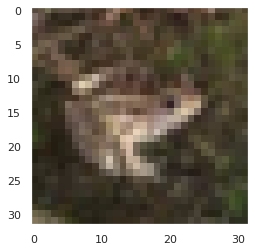

In [80]:
label = 6 
ims = np.where(train_labels == label)[0]  #indices with label 6
plt.imshow(train_images[ims[2]])

In [84]:
len(ims)

5000

Now define the gradient descent optimizer, and a function that will calculate the gradient of the error with respect to your typical image, using the optimizer to apply the gradient to the typical image.  Remember that you need to specify a learning rate for the optimizer.  You might need to later experiment with the learning rate to find the right value so the training will converge to the minimum (and converge quickly).  (__Note:__  "Normal" learning rates are typically in the range 0.1 to 1, perhaps even smaller in some situations.  The learning rate we used in our solution was 10.)  

In [148]:
def error(images,typ):
    return tf.reduce_mean(delta_func(images,typ))

def _gradients(images,typ):
    with tf.GradientTape() as tape:
        loss = error(images,typ)
    return tape.gradient(loss,[typ])

def SGD(images,typ,eta=10,steps = 1):
    for _ in range(steps):
        typ = typ - _gradients(images,typ)[0] * eta 
    return typ

In [149]:
def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg
typ = my_func(train_images[ims[0]])

You can compare this to the first four frog (class label 6) training images. A perfect fit, right?  

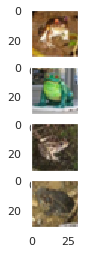

In [545]:
frogs = np.where(train_labels == 6)[0]   #  Get the indices for the frogs

fig, ax = plt.subplots(4, 1)
for i in range(4):
    np.ravel(ax)[i].imshow(train_images[ frogs[i] ])

plt.show()

In [842]:
#predicted_classes = return [0]*len(validation_images)

grader.score('tf__smallest_delta', arr1)

Your score:  3.597416576964478


## Softmax model

Looking only at the smallest distance is throwing some information away.  We would expect some classes to have more variation that others.  Also, we would expect correlation between the classes&mdash;a small distance to *cat* is probably more likely for *dog* than for *airplane*.

Instead of a trying to work out these effects heuristically, let the computer do it.  Build a softmax model that takes as input features the distances from all ten typical images and makes a class prediction from those.  Again, use this to predict the class for each of the validation images.

**Hint:**
- The labels are given as integers, but softmax expects one-hot encoding of the labels.  The `tf.one_hot` function can do the conversion.

In [844]:
from tensorflow.keras.utils import to_categorical as one_hot
from tensorflow import keras
x = keras.layers.Input(shape = (10,))
y = keras.layers.Dense(10, activation = 'softmax')(x)
cst = keras.models.Model(inputs=x, outputs=y)

y_train = one_hot(train_labels)

#predicted_classes = return [0]*len(validation_images)

cst.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.5),
              metrics=['accuracy'])

##magic cst.predit()

grader.score('tf__softmax', arr1)

Your score:  3.4329738058551618


**Extension:** Does this perform any better than the previous solution?  What metric is the right one to use to make this judgment?

## Fully-connected model

The previous model still makes the assumption that this distance metric is the right measure to use.  In this problem, we'll give this up.  Build a multi-layer fully-connected neural network that takes the pixel values as input and yields a class prediction as output.

**Hints:**
- We found that adding more layers didn't help too much.
- Watch out for overfitting.  Dropout can help with this.
- The reference solution achieves an accuracy of about 44% on a training set and 41% on a test set.

In [ ]:
train_labels1 = tf.one_hot(train_labels, 10).numpy()

In [ ]:
class DenseNeuralNetwork():
    def __init__(self, layer_shapes, eta=.1):
        self.layers = [(
            tf.Variable(tf.random.normal(shape)),
            tf.Variable(tf.zeros(shape[1]))
        ) for shape in layer_shapes]
        self.opt = tf.keras.optimizers.SGD(learning_rate=eta)

    def _logits(self, X):
        _ = X
        for W, b in self.layers[:-1]:
            _ = tf.nn.sigmoid(tf.matmul(_, W) + b)
        
        W, b = self.layers[-1]
        return tf.matmul(_, W) + b
    
    def loss(self, X, y, return_func=False):        
        def loss_():
            return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                logits=self._logits(X), labels=y))
        
        if not return_func:
            return loss_()
        
        return loss_
    
    def fit(self, X, y, steps=10):
        for _ in range(steps):
            self.opt.minimize(self.loss(X, y, return_func=True), [var for layer in self.layers for var in layer])
    
    def predict_proba(self, X):
        return tf.nn.sigmoid(self._logits(X))
        
    def predict(self, X):
        return tf.cast(self.predict_proba(X) > 0.5, dtype=tf.float32)
    
    def score(self, X, y):
        return tf.reduce_mean(tf.cast(tf.equal(self.predict(X), y), dtype=tf.float32))

In [ ]:
hidden_size = 2

layers = [(2, hidden_size), (hidden_size, 1)]

dnn = DenseNeuralNetwork(layers, eta=.5)

for i in range(10):
    dnn.fit(data, labels, 300)
    print('Loss: {}'.format(dnn.loss(data, labels)))
    print('Accuracy: {}'.format(dnn.score(data, labels)))

In [845]:
#predicted_classes = return [0]*len(validation_images)

grader.score('tf__fully_connected', arr1)

Your score:  2.270380434782609


## Convolutional model

Convolutional neural networks have had a lot of success in image classification.  Build a neural network with convolutional layers to improve the performance.

**Hints:**
- The reference solution uses two convolutional layers and two fully-connected layers.
- We found success with the `AdamOptimizer`.
- The reference solution achieves an accuracy of roughly 80% on a training set and 70% on a test set.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

import time
from datetime import datetime, timedelta

import pylib.conv_widget as cw
from pylib.tensorboardcmd import tensorboard_cmd

In [ ]:
# Model parameters
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 50
n_epochs = 5

model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.1),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

In [ ]:
def predict(idx):
    image = np.array([X_test[idx]])
    return np.argmax(model.predict(image))

In [846]:
#predicted_classes = return [0]*len(validation_images)

grader.score('tf__convolutional', arr1)

Your score:  1.0655188904830226


## Transfer learning

In transfer learning, we use a network trained on one data set to provide a starting point for the modeling of other data.  As we are trying to model color images, we should look for another network trained on color images.  Luckily, we have already discussed such a network: the Inception network used in the Deep Dream notebook.

The following cell will load the model, omitting its classification layer (since we're not interested in classifying `ImageNet` images).

In [ ]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In a transfer learning setup, we will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network.  There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers.  Data will flow through the pre-trained layers as well as those added.  In the training step, only the new layers should be marked as trainable.

However, this can be a bit wasteful when multiple epochs of training will be undertaken since we recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions.  We recommend this approach for this miniproject.

Images should be fed to the `inception` network and then vectorized (you might want to refer to the `TF_DeepDream.ipynb` notebook).

We've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that we need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize` with bilinear interpolation.  (More sophisticated resizing methods produce better results, but will take significantly longer!)

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily.  You also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

**Hints:**
- Be sure to batch this calculation; resizing all 50,000 images at once will cause memory errors.
- The latent vector calculation took us between 30 minutes and 2 hours on a single machine.  You might consider distributing the calculation.
- The latent vectors for the first 10 images have an average of 1983 non-zero values and an overall average value of 0.319.

With the latent vectors calculated, we can use them as input to train a small neural network to make the final predictions.

**Hints:**
- The reference solution has three layers.
- The reference solution achieves a training accuracy of 87% and a test accuracy of 85%.

In [ ]:
for batch in range(50):
    train_subset = train_images[(batch * 1000):(batch + 1) * 1000]
    list_to_save = []
    for i in range(100):
        ##Magic
    arr_to_save = np.array(list_to_save)
    np.save(f"latent_cache/batch_{batch}", arr_to_save)
    print(batch)

In [ ]:
for batch in range(10):
    val_subset = validation_images[(batch * 1000):(batch + 1) * 1000]
    list_to_save = []
    for i in range(100):
        ##Magic
    arr_to_save = np.array(list_to_save)
    np.save(f"latent_cache/val_batch_{batch}", arr_to_save)
    print(batch)

In [847]:
#predicted_classes = return [0]*len(validation_images)

grader.score('tf__transfer_learning', arr1)

Your score:  0.9029991894082681


*Copyright &copy; 2020 Pragmatic Institute. This content is licensed solely for personal use. Redistribution or publication of this material is strictly prohibited.*